In [17]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
%matplotlib inline

In [19]:
data_dir ='./data'
print(os.listdir(data_dir)[:3])

['test', 'train', 'val']


In [21]:
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train', 'val']
['diseased cotton leaf', 'diseased cotton plant', 'fresh cotton leaf', 'fresh cotton plant']


In [23]:
diseased_cotton_leaf = os.listdir(data_dir + "/train/diseased cotton leaf")
print('No. of training examples for diseased cotton leaf:', len(diseased_cotton_leaf))
print(diseased_cotton_leaf[:5])

No. of training examples for diseased cotton leaf: 288
['dis_leaf (1)_iaip.jpg', 'dis_leaf (10)_iaip.jpg', 'dis_leaf (101)_iaip.jpg', 'dis_leaf (102)_iaip.jpg', 'dis_leaf (103)_iaip.jpg']


In [25]:
for i in classes:
    result=os.listdir(data_dir + "/train/" + i)
    print(f"Number Of Images in {i} = {len(result)}")

Number Of Images in diseased cotton leaf = 288
Number Of Images in diseased cotton plant = 815
Number Of Images in fresh cotton leaf = 427
Number Of Images in fresh cotton plant = 421


In [27]:
image_size = 32
batch_size = 128
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [29]:
train_ds = ImageFolder(data_dir + "/train", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),T.Normalize(*stats)]))
val_ds = ImageFolder(data_dir + "/val", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),T.Normalize(*stats)]))

In [31]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [33]:
img, label=train_ds[0]
img

tensor([[[ 0.2461,  0.3236,  0.2848,  ..., -0.0060, -0.4712, -0.2386],
         [ 0.5174,  0.5756,  0.3624,  ...,  1.0990,  0.5562,  0.0134],
         [ 0.7113,  0.7888,  0.7501,  ...,  0.9245,  0.9827,  0.8470],
         ...,
         [ 0.8664,  1.0021,  1.0602,  ..., -0.3355, -0.3161, -0.3161],
         [ 0.9051,  1.0602,  1.2735,  ..., -0.4324, -0.4324, -0.1029],
         [ 0.7694,  0.8276,  0.9439,  ..., -0.5875, -0.4712, -0.0253]],

        [[ 1.7511,  1.8298,  1.9281,  ...,  0.8858,  0.4138,  0.6104],
         [ 1.9281,  1.9675,  1.9281,  ...,  2.2035,  1.5741,  0.9448],
         [ 2.0068,  2.0461,  2.0265,  ...,  2.1641,  2.1838,  2.0855],
         ...,
         [ 1.9871,  2.0265,  2.0068,  ..., -0.5499, -0.4909, -0.4909],
         [ 2.0265,  2.0855,  2.1248,  ..., -0.5696, -0.5499, -0.3139],
         [ 1.9281,  1.9478,  2.0265,  ..., -0.6876, -0.6286, -0.2746]],

        [[-0.2899, -0.4460, -0.8167,  ...,  0.0808, -0.4069, -0.3679],
         [ 0.1394, -0.0362, -0.6411,  ...,  0

In [35]:
img, label=train_ds[0]
img.shape

torch.Size([3, 32, 32])

In [37]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [45]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [41]:
show_batch(train_dl)
torch.cuda.empty_cache()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0167307].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


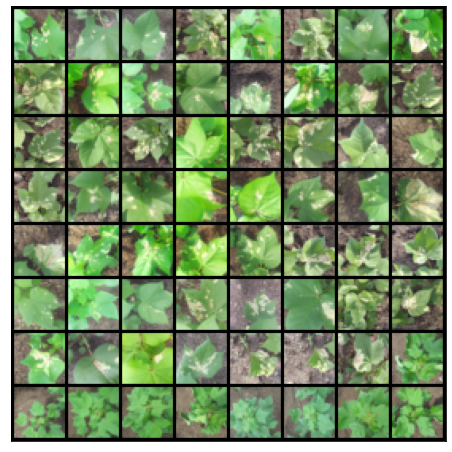

In [67]:
show_batch(val_dl)

In [68]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [69]:
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             3x32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 4))
        
    def forward(self, xb):
        return self.network(xb)

In [70]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512

In [71]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 4])
out[0]: tensor([-0.0210, -0.0320, -0.0447,  0.0404], grad_fn=<SelectBackward>)


In [72]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [73]:
device = get_default_device()
device

device(type='cuda')

In [74]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [76]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [77]:
model = to_device(CnnModel(), device)

In [78]:
evaluate(model, val_dl)

{'val_loss': 1.396937370300293, 'val_acc': 0.107421875}

In [79]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 0.001

In [81]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.5597, val_loss: 0.5147, val_acc: 0.7973
Epoch [1], train_loss: 0.3127, val_loss: 0.3878, val_acc: 0.8521
Epoch [2], train_loss: 0.2624, val_loss: 0.3831, val_acc: 0.8624
Epoch [3], train_loss: 0.2208, val_loss: 0.2333, val_acc: 0.9129
Epoch [4], train_loss: 0.2052, val_loss: 0.3052, val_acc: 0.8991
Epoch [5], train_loss: 0.1433, val_loss: 0.2531, val_acc: 0.9041
Epoch [6], train_loss: 0.1546, val_loss: 0.3260, val_acc: 0.8851
Epoch [7], train_loss: 0.1591, val_loss: 0.2070, val_acc: 0.9261
Wall time: 2min 26s


In [82]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

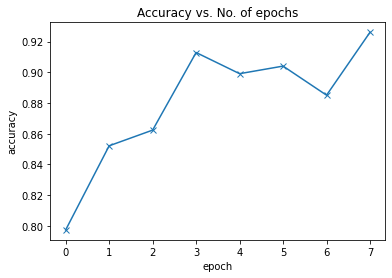

In [83]:
plot_accuracies(history)

In [84]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

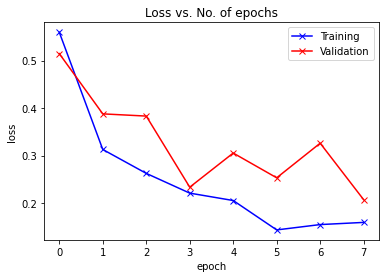

In [85]:
plot_losses(history)

In [86]:
test_dataset = ImageFolder(data_dir + "/test", transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),T.Normalize(*stats)]))

In [87]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [88]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [89]:
torch.save(model.state_dict(), 'modelCottonDemo.pth')

Label: diseased cotton leaf , Predicted: diseased cotton leaf


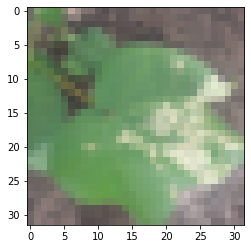

In [91]:
test_dataset1 = ImageFolder(data_dir+'/test', transform=ToTensor())
img, label = test_dataset[0]
plt.imshow(denorm(img.permute(1, 2, 0)))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [3]:
torch.cuda.empty_cache()